# Exercise: Julia Set on NVIDIA GPU

<img src="../imgs/juliaset.svg" width=700>

In this exercise, we will revisit the problem of computing an image of the [Julia set](https://en.wikipedia.org/wiki/Julia_set) from earlier. This time we will compare the sequential CPU variant to a parallel GPU implementation, using a custom CUDA kernel.

In [1]:
using CUDA
using Plots
using BenchmarkTools

@assert CUDA.functional()

const MAX_THREADS_PER_BLOCK = CUDA.attribute(device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK);

The value of a single pixel (`i,j` coordinates) of the Julia set can be computed with the following function. A pixel corresponds to a point `z` in the complex number plane and the value of the pixel is the number of performed iterations for the corresponding complex number `z`.

In [2]:
"""
Computes a pixel (`i`, `j`) in the Julia set image
(of size `n`x`n`). It returns the number of iterations.
"""
function _compute_pixel(i, j, n; max_iter=255, c=-0.79f0 + 0.15f0 * im)
    x = Float32(-2.0 + (j - 1) * 4.0 / (n - 1))
    y = Float32(-2.0 + (i - 1) * 4.0 / (n - 1))

    z = x + y * im
    iter = max_iter
    for k in 1:max_iter
        if abs2(z) > 4.0
            iter = k - 1
            break
        end
        z = z^2 + c
    end
    return iter
end

_compute_pixel

**We will run this function on the CPU and GPU below!**

## CPU

**Task 1:** Utilizing the function `_compute_pixel!(i,j,n)` from above, implement the function `compute_juliaset_cpu(N)` below and verify (by plotting) that you actually get the desired Julia set image
  * Hint: Use the `heatmap` function to generate the plot.

In [3]:
function compute_juliaset_cpu(N)
    img = zeros(Int32, N, N)
    #
    # TODO: loop over the image matrix and compute each pixel by
    #       calling the `_compute_pixel` function above.
    #
    for j in 1:N
        for i in 1:N
            # TODO
            iter = _compute_pixel(i, j, N)
            @inbounds img[i, j] = iter
        end
    end
    return img
end

compute_juliaset_cpu (generic function with 1 method)

Check that everything works (should produce the Julia set image):

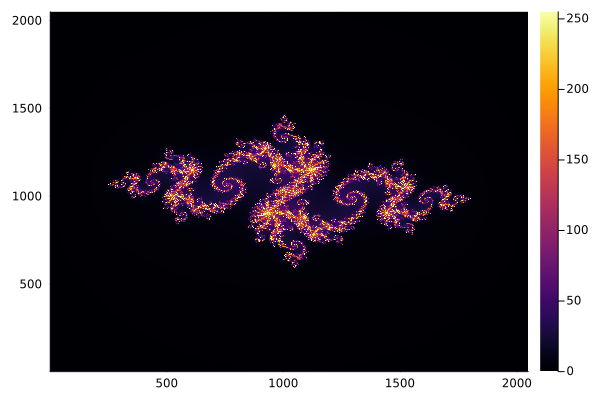

In [4]:
N = 2048
#
# TODO: compute the julia set image and plot it
#
img_cpu = compute_juliaset_cpu(N)
heatmap(img_cpu)

## GPU (CUDA kernel)

**Task 2:** Utilizing the function `_compute_pixel!(i,j,n)` from above, implement the CUDA kernel `_compute_pixel_gpu!(img)` and the function `compute_juliaset_gpu(N)` that calls this kernel below. Verify (by plotting and comparing the result to `compute_juliaset_cpu(N)`) that you actually get the desired Julia set image.

In [5]:
function _compute_pixel_gpu!(img)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    #
    # TODO: Complete this CUDA kernel that should use the function `_compute_pixel` to
    #       compute a single pixel of the image. The result should be written into the
    #       correct position of `img`.
    #
    n = size(img, 1)
    if (i ≤ n && j ≤ n)
        iter = _compute_pixel(i, j, n)
        @inbounds img[i, j] = iter
    end
    return nothing
end

function compute_juliaset_gpu(N)
    img_gpu = CUDA.zeros(Int32, N, N)
    threads = (isqrt(MAX_THREADS_PER_BLOCK), isqrt(MAX_THREADS_PER_BLOCK))
    blocks = cld.((N, N), threads)
    #
    # TODO: 1. Call the GPU kernel that you've written above.
    #          (the variables `threads` and `blocks` indicate the launch configuration)
    #       2. Afterwards, copy the image (`img_gpu`) to the host memory (`img_cpu`).
    #
    CUDA.@sync begin
        @cuda threads = threads blocks = blocks _compute_pixel_gpu!(img_gpu)
    end
    img_cpu = Array(img_gpu)
    return img_cpu
end

compute_juliaset_gpu (generic function with 1 method)

Check that everything works (should produce the Julia set image):

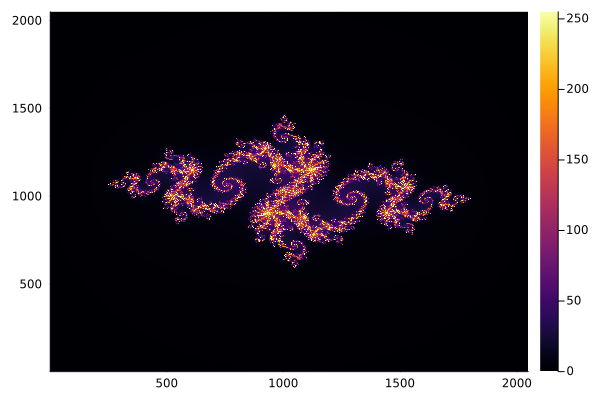

In [6]:
N = 2048
#
# TODO: compute the julia set image on the GPU and plot it
#
img_gpu = compute_juliaset_gpu(N)
heatmap(img_gpu)

In [11]:
println("CPU and GPU images match: ", img_cpu ≈ img_gpu)

CPU and GPU images match: true


## Benchmark

**Task 3:** Run the following benchmark that compares the variants above and also tries to estimate the time it takes to transfer the data from the GPU to the host.

In [18]:
N = 2048

t_cpu = @belapsed compute_juliaset_cpu($N) samples = 10 evals = 3
t_gpu = @belapsed compute_juliaset_gpu($N) samples = 10 evals = 3
t_transfer = @belapsed Array(img_gpu) setup = (img_gpu = CUDA.zeros(Int32, $N, $N)) samples = 10 evals = 3

println("CPU (sequential):\t", round(t_cpu * 1e3; digits=2), "ms")
println("GPU (incl. data transfer):\t", round(t_gpu * 1e3; digits=2), "ms")
println("GPU (w/o data transfer):\t", round((t_gpu - t_transfer) * 1e6; digits=2), "μs")

CPU (sequential):	186.59ms
GPU (incl. data transfer):	1.88ms
GPU (w/o data transfer):	419.17μs


**Questions:** Imagine we could parallelize the CPU code (`compute_juliaset_cpu`) perfectly on a full Noctua 2 compute node with 128 CPU-cores (e.g. with multithreading).

1) What would be the runtime of this CPU-parallel variant?
2) Would the GPU computation (including data transfer) still be faster?

**Answers:**

1) $t_{\textrm{sequential}} / 128 \approx 186 \textrm{ ms } / 128 \approx 1.45 \textrm{ ms}$
2) Likely not, no.